In [1]:
import os
os.chdir('..')

In [2]:
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

figures_folder = '../figures/'
results_folder = './server/parameters/results/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [44]:
params = ['thresh_upd', 'count_upd', 'window', 'factor_upd', 'perc_hybrid', 'stop_crit']

str_params = {
    'thresh_upd': '$\Delta$ [%]',
    'count_upd': '$C$',
    'window': '$W$',
    'factor_upd': '$\\tau$',
    'perc_hybrid': '$\Delta_H$ [%]',
    'stop_crit': '$\\varepsilon$'
}

ylim = {'thresh_upd': [0, 10],
          'count_upd': [0, 7],
          'window': [0.5, 4],
          'factor_upd': [0.5, 5],
          'perc_hybrid': [0.5, 3],
          'stop_crit': [0.5, 30]}

base_param = {'perc_hybrid': 30, 'thresh_upd': 1.0, 'count_upd': 2, 'window': 10, 'factor_upd': 2, 'stop_crit': 1e-6}

## Prepare Full 

In [45]:
full = {}

for p in ['base', 'count', 'window', 'factor', 'hybrid', 'stop_crit', 'thresh']:
    res = json.load(open(results_folder + 'Full_' + p + '.json'))
    
    for k in res.keys():
        full[k] = res[k]

In [46]:
with open(results_folder + 'parameters_Full.json', 'w') as outfile:
    json.dump(full, outfile)

In [47]:
def to_str(k):
    
    if k == 0.0:
        return "0"
    elif k < 1 or not (k).is_integer():
        return str(k)
    else:
        return str(int(k))


base 2.657676911354065
thresh_upd 2.6037832379341124
count_upd 2.559278154373169
window 2.5578163981437685
factor_upd 2.554374086856842
perc_hybrid 2.5365108609199525
stop_crit 2.618348741531372

base 16.64473867416382
thresh_upd 16.500969767570496
count_upd 17.086921012401582
window 16.321442949771882
factor_upd 16.102118360996247
perc_hybrid 16.2591274023056
stop_crit 16.243697893619537

base 419.7609348297119
thresh_upd 394.7416553378105
count_upd 402.56843136548997
window 377.39644120931627
factor_upd 379.69768050909045
perc_hybrid 387.6338879704475
stop_crit 397.90607048273085


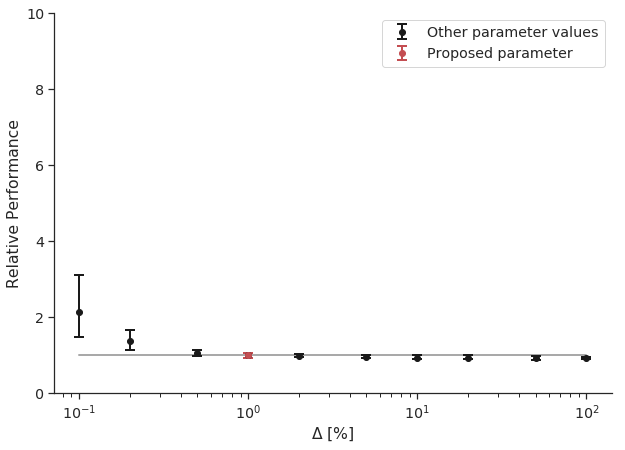

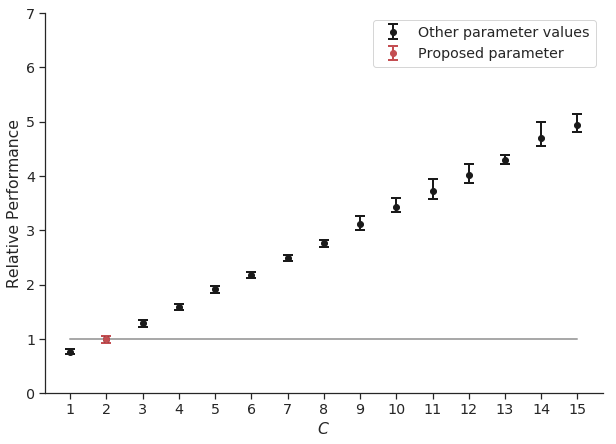

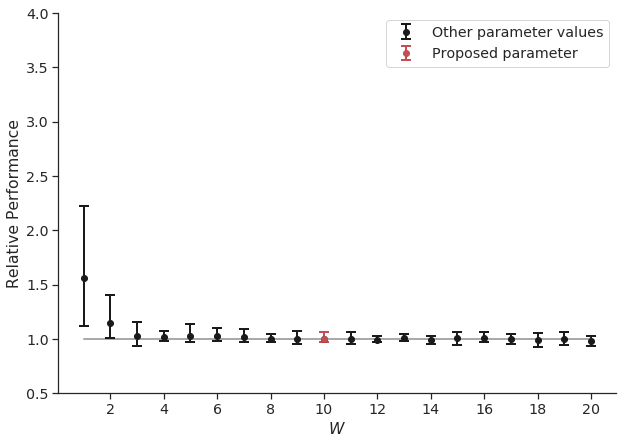

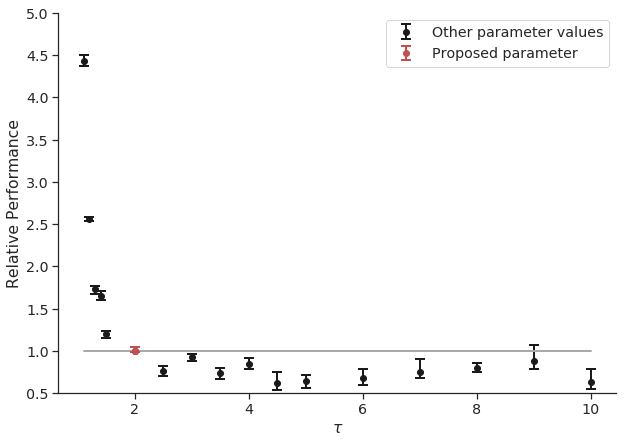

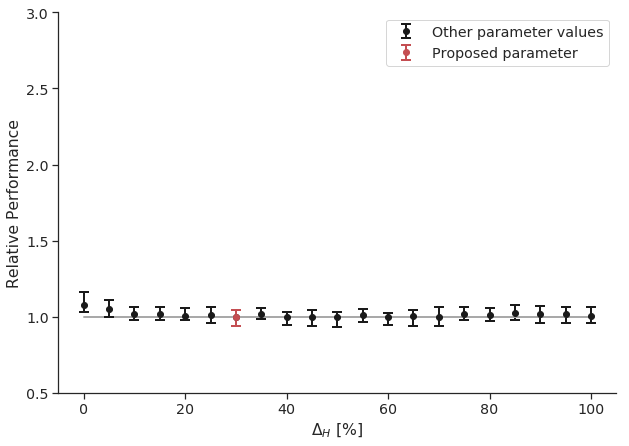

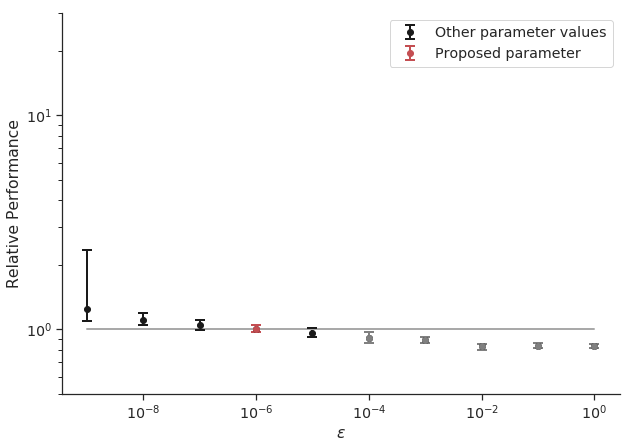

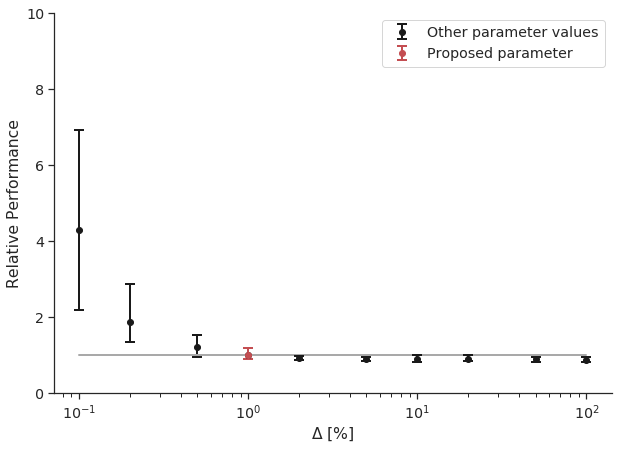

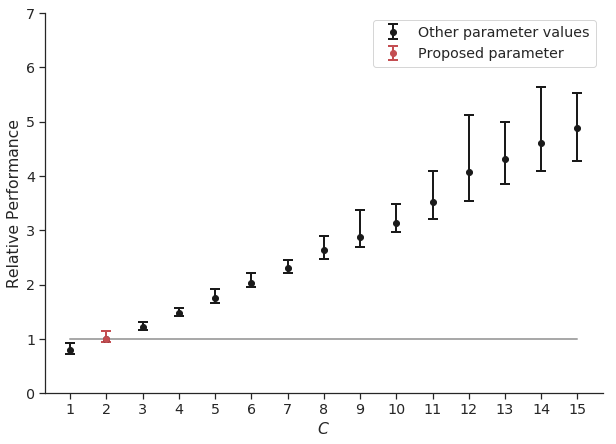

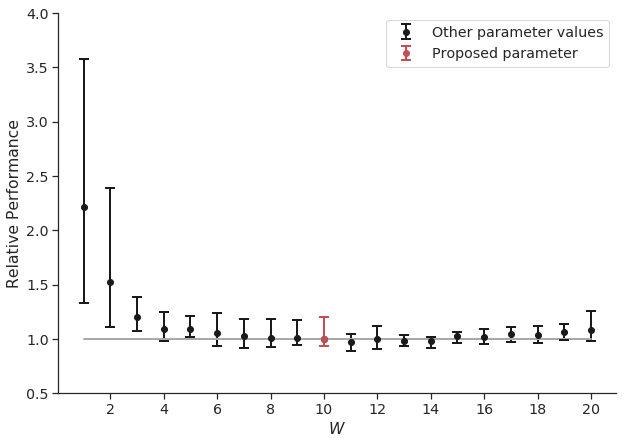

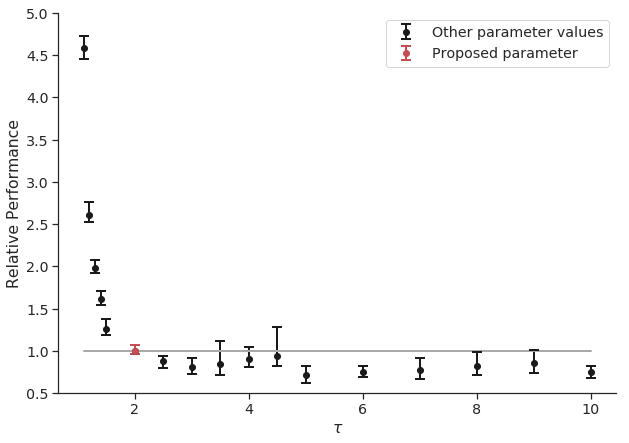

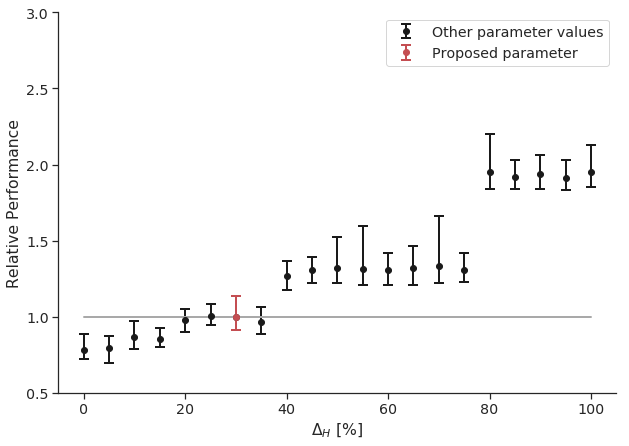

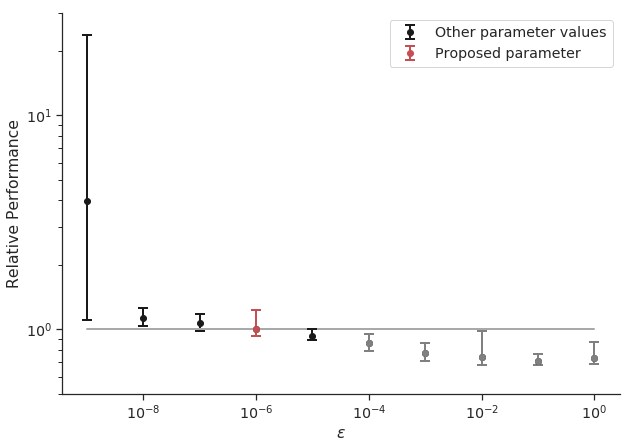

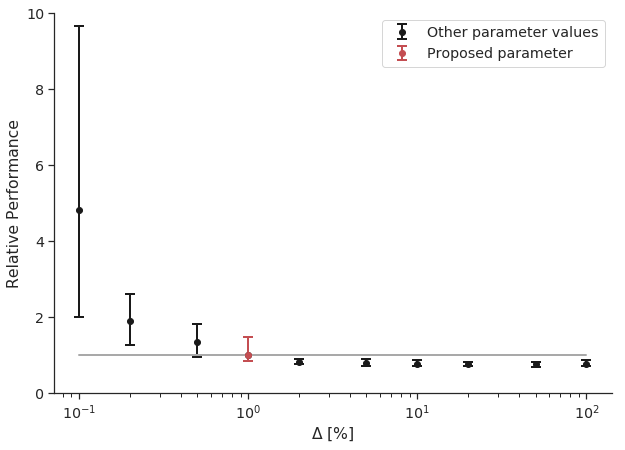

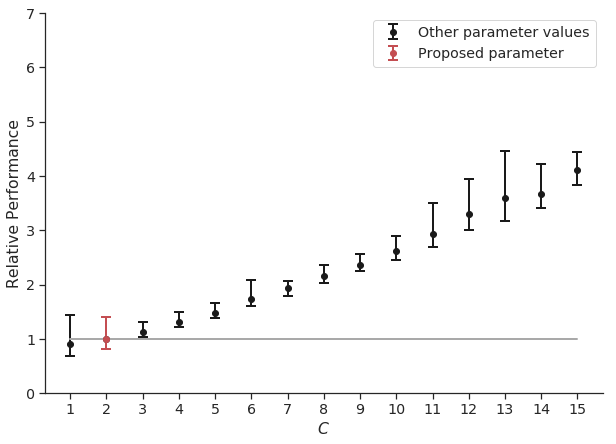

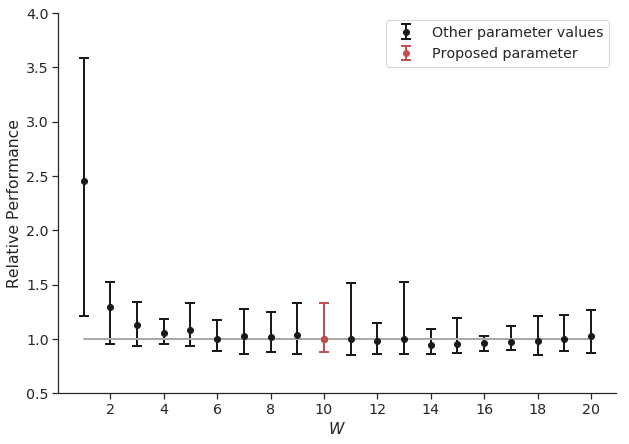

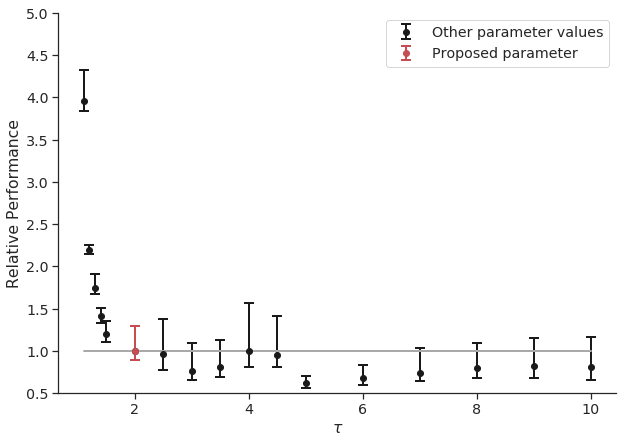

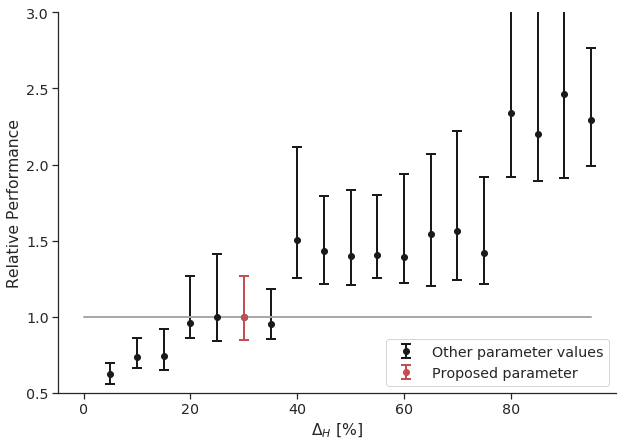

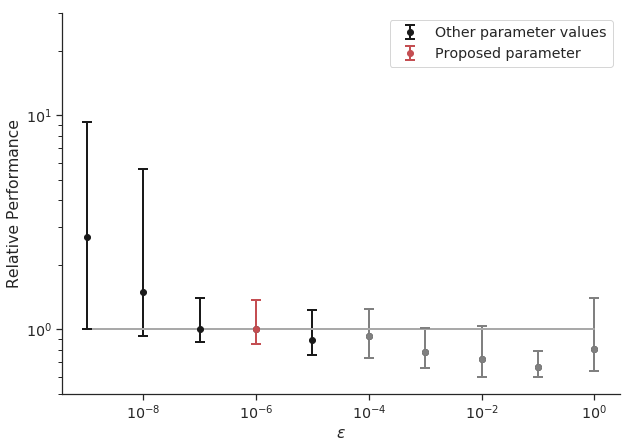

In [48]:
for model in ['DC', 'RR', 'Full']:
    file = 'parameters_' + model + '.json'
    
    res = json.load(open(results_folder + file))
    
    time = res['base']['time']
    
    avg_ll = np.mean(res['base']['LL'])
    
    avg = np.mean(time)
    
    print()
    print('base', avg)
        
    for p in params:
            
        tmp = res[p]

        keys = list(map(float, tmp.keys()))
        keys.sort()
        
        if p == 'count_upd':
            keys = list(np.array(keys)[np.array(keys) <= 15])
        
        if len(keys) > 0:

            if p == 'stop_crit':
                func = lambda x: str(x)
            else:
                func = lambda x: to_str(x)                

            avg_lls = [np.mean(tmp[func(k)]['LL']) for k in keys]

            plt.figure(figsize=(10, 7), frameon=False)

            sns.set_context("paper")
            sns.set(font_scale = 1.3)
            sns.set_style("white", {
                "font.family": "sans-serif",
                "font.serif": ['Helvetica'],
                "font.scale": 2
            })
            sns.set_style("ticks", {"xtick.major.size": 4,
                                    "ytick.major.size": 4})

            ax = plt.subplot(111)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            idx = keys.index(base_param[p])
            plt.plot([keys[0], keys[-1]], [1, 1], linewidth=2, color='darkgrey') 

            avg = np.mean(tmp[func(float(base_param[p]))]['time'])
            
            print(p, avg)
            
            err_down = [np.mean(tmp[func(k)]['time']/avg)-np.percentile(tmp[func(k)]['time']/avg, 2.5) for k in keys]
            err_up = [np.percentile(tmp[func(k)]['time']/avg, 97.5)-np.mean(tmp[func(k)]['time']/avg) for k in keys]
            err_avg = [np.mean(tmp[func(k)]['time']/avg) for k in keys]
            
            avg_lls = [np.mean(tmp[func(k)]['LL']) for k in keys]      

            p1 = plt.errorbar(keys, err_avg, yerr=[err_down, err_up], fmt='o', elinewidth=2, capthick=2, capsize=5, color='k')

            p2 = plt.errorbar(keys[idx], err_avg[idx], yerr=[[err_down[idx]], [err_up[idx]]], fmt='o', linewidth=2, capthick=2, capsize=5, color='r')

            bad_opti = np.abs(avg_lls-avg_ll) > 1e-5
            idx = np.array(range(len(keys)))[bad_opti]

            if len(idx) > 0:
                plt.errorbar(np.array(keys)[bad_opti], np.array(err_avg)[bad_opti], yerr=[np.array(err_down)[bad_opti], np.array(err_up)[bad_opti]], fmt='o', linewidth=2, capthick=2, capsize=5, color='gray')

            plt.xlabel(str_params[p])
            plt.ylabel('Relative Performance')
            leg = plt.legend([p1, p2], ['Other parameter values', 'Proposed parameter'], frameon=True)  

            if p in ['thresh_upd', 'stop_crit']:
                plt.xscale('log')

            if p in ['stop_crit']:
                plt.yscale('log')

            plt.ylim(ylim[p])

            if p == 'window':
                plt.xticks([2,4,6,8,10,12,14,16,18,20])
            elif p == 'count_upd':
                plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

            plt.savefig(figures_folder + 'png/effect_{}_{}.png'.format(p, model), bbox_inches='tight')
            plt.savefig(figures_folder + 'pdf/effect_{}_{}.pdf'.format(p, model), bbox_inches='tight')